# 2D mesh for TOUGH (Part 1)

In this example we want to create a mesh for the simulation of CO2-injection into the subsurface. For the domain we assume a layer of sandstone with some thickness and some topology. Also, we assume that the flow processes in z-direction are faster than the flow processes in x-direction. For this reason we choose small cell sizes in z-direction and larger cell sizes in x-direction.

We calculate the points resulting in a rectangular mesh with `xymesh()` (See code for details) 

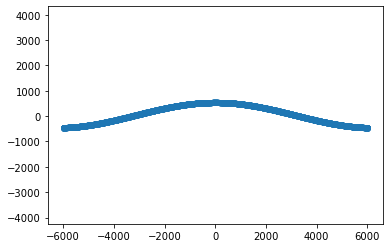

In [38]:
import xymesh
import matplotlib.pyplot as plt

points = xymesh.xymesh()

plt.plot(points[:,0], points[:, 1], '.')
plt.axis("equal")
plt.show()

Here we cannot see any points. For this reason, we zoom a little bit.

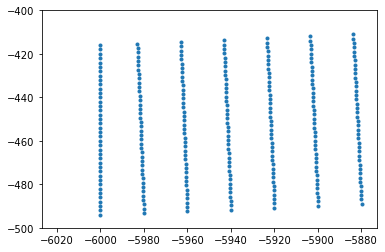

In [19]:
plt.plot(points[:,0], points[:, 1], '.')
#
plt.axis('equal')
plt.xlim(-6000, -5900)
plt.ylim(-500, -400)
plt.show()

When we look at the general view, we can see that the convex hull is a bad approximation for the boundary of this shape. For this reason, we need to think of something else.

Here we triangulate the points. When look at a measure for the shape of the triangles, we can easily identify acute and very acute triangles. When we look at the triangles in detail, we can see, that the acute triangles are inside our shape and the very acute triangles are outside our shape. Now the next step is to define a limit to get rid of the very acute triangles. This limit can be found from the histogram.

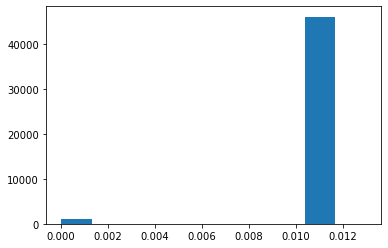

In [20]:
from shapely import MultiPoint
from shapely.ops import triangulate, unary_union

tri = triangulate(MultiPoint(points))

param = [region.area/(region.length**2) for region in tri]
plt.hist(param)
plt.show()

We select the limit somewhere between the two distributions. 

Then we remove all triangles smaller than the given limit and merge the remaining triangles into a boundary. This boundary is buffered by 1.0, because the mesh size in z-direction is 2.0. The resulting shape is the boundary for the Voronoi decompostion.

In [21]:
limit = 0.005

tri = [region for region in tri if region.area/(region.length**2) > limit]

boundary = unary_union(tri).buffer(1)

Now we can create the Voronoi mesh using the points and the boundary from above. We use `layersfromsurf()` to make the mesh 3D.
 
When we convert the mesh to pyvista, the mesh is an xy-mesh. But we want to have xz-mesh. For this reason, we need to switch dimensions.

from voromesh import Voronoi
from voromesh.geo import layersfromsurf

voro = Voronoi(points, boundary=boundary)
mesh = voro.to_pyvista()

# Make mesh 3D
mesh = layersfromsurf(mesh, [1])
mesh.points[:, [1, 2]] = mesh.points[:, [2, 1]]

# mesh.save("mesh.vtu")

Finally the mesh is prepared and we can have a look. It is not very comfortable to view this mesh using Paraview. It is better to save the mesh to a file and look at the mesh with [Paraview](https://www.paraview.org/).

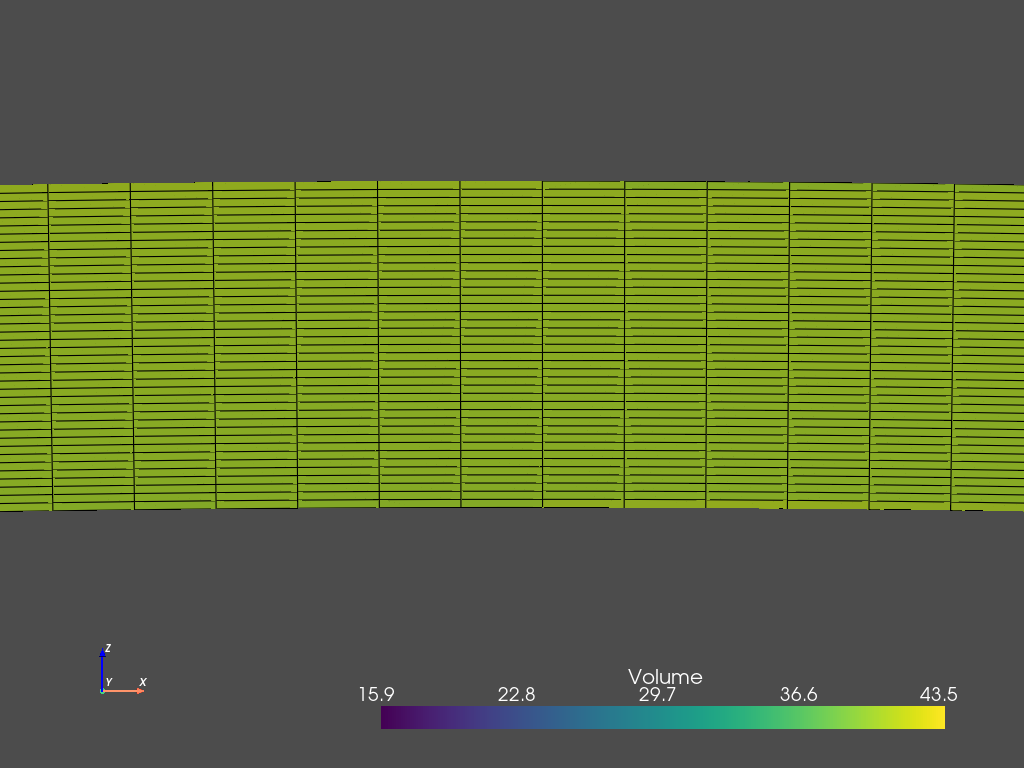

In [37]:
import pyvista as pv

pv.set_jupyter_backend('static')

cpos = [
    (-2.6839675192310253, -351.165133741359, 530.2535661651707),
    (-2.6839675192310253, 0.5, 530.2535661651707),
    (0.0, 0.0, 1.0),
]

mesh.plot(notebook=True, show_edges=True, cpos=cpos)